In [102]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')

%load_ext autoreload
%autoreload 2
%matplotlib inline

home_path = 'C:\\Users\joche\FIM Kernkompetenzzentrum\Projekt VIdES - Dokumente\General\\07_Arbeitsordner\\04_Ergebnisse\\20220920_Ergebnisse_4_Wochen'
os.chdir(home_path)
out_path = r'C:\Users\joche\FIM Kernkompetenzzentrum\Projekt VIdES - Dokumente\General\07_Arbeitsordner\04_Ergebnisse\20220920_Ergebnisse_4_Wochen\results\Abbildungen\v04/top_down/'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [103]:
# define path for use case 3_v2
uc_path = r'C:\Users\joche\FIM Kernkompetenzzentrum\Projekt VIdES - Dokumente\General\07_Arbeitsordner\04_Ergebnisse\20220920_Ergebnisse_4_Wochen\results\Use_Case_3_v2'
fpath = [i.path for i in os.scandir(uc_path) if 'kpi_3_4' in i.name if '.xlsx' in i.name][0]
# read in file
df = pd.read_excel(fpath, index_col=0)

In [104]:
df[['grid_grey_energy [kWh]']].sum(axis=0)

grid_grey_energy [kWh]    94270.070716
dtype: float64

In [105]:
# define path for GSy file
gsy_path = [i.path for i in os.scandir(uc_path) if 'total_germany.xlsx' in i.name][0]
df_gsy = pd.read_excel(gsy_path).iloc[:,1:]

In [106]:
df_gsy['Imported_kWh']

0    300931.483973
Name: Imported_kWh, dtype: float64

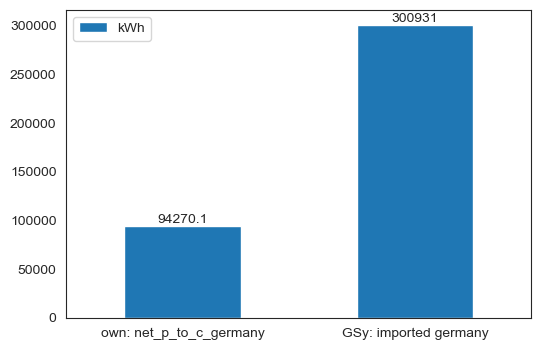

In [107]:
# compare both values
df_out = pd.DataFrame([df[['grid_grey_energy [kWh]']].sum(axis=0).values[0], df_gsy['Imported_kWh'].values[0]], index=['own: net_p_to_c_germany', 'GSy: imported germany'], columns=['kWh'])
l = df_out.plot.bar(rot = 0, figsize = (6,4))
plt.bar_label(l.containers[0])
plt.show()

In [108]:
# define path for uc 3 v2
use_case_home_path = r'C:\Users\joche\FIM Kernkompetenzzentrum\Projekt VIdES - Dokumente\General\07_Arbeitsordner\04_Ergebnisse\20220920_Ergebnisse_4_Wochen\use_case_3_v2'
import functions_topdown_v1 as f1

# get all nonempty monthly files
nonempty_files_paths, empty_files_paths, nr_months, l, df_out = f1.prepare_filepaths(use_case_home_path)
# filter out relevant paths: Trades of regions' market maker
rel_paths = [i for i in nonempty_files_paths if 'member-region' in i.split('\\')[-1]]

# for all regions, combine monthly dfs
l = len(rel_paths)
dfs_out = []
for i in range(int(l / nr_months)):
    entity_monthly_dfs = []
    entity_monthly_filepaths = nonempty_files_paths[i::int(l / nr_months)]
    for j in entity_monthly_filepaths:
        df_temp = pd.read_csv(j).drop(['creation_time', 'matching_requirements', 'rate [ct./kWh]'], axis=1)
        df_temp.seller = [i.lower().replace('_', '-') for i in df_temp.seller]
        df_temp.buyer = [i.lower().replace('_', '-') for i in df_temp.buyer]
        entity_monthly_dfs.append(df_temp)
    entity_name = entity_monthly_filepaths[0].split('\\')[-1].split('-trades.csv')[0]
    entity_df = pd.concat(entity_monthly_dfs).sort_values(by='slot').reset_index(drop=True)
    entity_df.set_index(['slot'], inplace=True)
    dfs_out.append(entity_df)


In [109]:
# calculate cumulated energy sold/bought by market makers (to regions)
mm_sold, mm_bought = 0, 0
for i in dfs_out:
    df = i
    mm_sold += df.loc[(df.seller.str.contains('mm')) & (~df.buyer.str.contains('mm')),'energy [kWh]'].sum(axis=0)
    mm_bought += df.loc[(~df.seller.str.contains('mm')) & (df.buyer.str.contains('mm')),'energy [kWh]'].sum(axis=0)

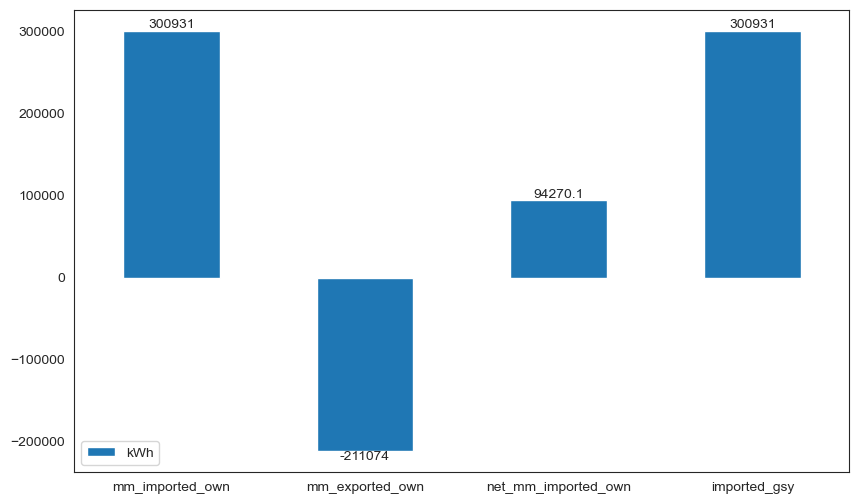

In [110]:
# create df for plotting
own_calc_net_p_to_c = 94270.070716
gsy_calc_imported = 300931.483973
df_out = pd.DataFrame([mm_sold, -mm_bought, own_calc_net_p_to_c, gsy_calc_imported], index=['mm_imported_own', 'mm_exported_own', 'net_mm_imported_own', 'imported_gsy'], columns=['kWh'])
l = df_out.plot.bar(rot = 0, figsize = (10,6))
plt.bar_label(l.containers[0])
plt.show()